In [1]:
import pandas as pd
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from sklearn.metrics import r2_score
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.collections import QuadMesh
import matplotlib as mpl

def annotate_metrics(x, y, ax=None, **kwargs):
    """
    Annotate MAE, RMSE, and R² directly on the graph as red text.
    """
    ax = ax or plt.gca()
    mae = np.mean(np.abs(x - y))
    rmse = np.sqrt(np.mean((x - y) ** 2))
    r2 = r2_score(x, y)
    ax.text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}',
            transform=ax.transAxes, fontsize=15, color='red', ha='left', va='top')

def density_hist2d(x, y, ax=None, bins=1000, range=None, **kwargs):
    """
    Create a 2D histogram colored by log(count) to show density.
    """
    ax = ax or plt.gca()
    
    h = ax.hist2d(x, y, bins=bins, range=range, norm=LogNorm(), cmap='viridis')
    
    # h is a tuple: (counts, xedges, yedges, image)
    # We return the image so we can potentially create a global colorbar outside.
    return h


def density_scatter(x, y, ax=None, bins=100, range=None, **kwargs):
    ax = ax or plt.gca()
    # Remove any existing 'color' or 'c' from kwargs to avoid conflicts
    kwargs.pop('color', None)
    kwargs.pop('c', None)
    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range)
    
    # Find bin indices for each point
    x_bin = np.searchsorted(xedges, x, side='right') - 1
    y_bin = np.searchsorted(yedges, y, side='right') - 1
    in_range = (x_bin >= 0) & (x_bin < len(xedges)-1) & (y_bin >= 0) & (y_bin < len(yedges)-1)
    x_in = x[in_range]
    y_in = y[in_range]
    x_bin = x_bin[in_range]
    y_bin = y_bin[in_range]
    
    point_density = counts[x_bin, y_bin]
    log_density = np.log10(point_density + 1)

    norm = Normalize(vmin=log_density.min(), vmax=log_density.max())
    cmap = cm.get_cmap('viridis')
    colors = cmap(norm(log_density))

    scatter = ax.scatter(x_in, y_in, c=colors, **kwargs)
    
    # Store the norm and cmap as attributes on the scatter for later retrieval
    scatter.norm = norm
    scatter.cmap = cmap
    
    return scatter

def equalityline(x, y, ax = None, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    ax = ax or plt.gca()
    ax.plot(lims, lims, **kwargs)

def m(x, y, ax = None, **kwargs):
    
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    m =(np.sum((x - y)**2, axis=0)/(y.shape[0]))**0.5
    ax.annotate(f'$RMSE= {float(m):.2f}$',
                xy=(.01, .99), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')   
    
def kde(x, y, ax = None, **kwargs):
    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x = np.array(x)
        y = np.array(y)
    ax = ax or plt.gca()
    kernel = stats.gaussian_kde(x)(y)
    ax.scatter(x, y, c=kernel, s=5)

ModuleNotFoundError: No module named 'seaborn'

Load the parquet charge models 

In [2]:
df = pd.read_parquet('/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/comparison_of_charge_models/charge_models_test.parquet')
df

mbis_charges  \
0      [-0.22269026300546416, 0.0986548857271199, -0....   
1      [-0.307478181466797, -0.32475236546718506, 0.0...   
2      [0.18318003045342993, -0.2598634431943842, -0....   
3      [-0.27024134000385275, -0.2514930826279807, 0....   
4      [-0.25576208790277083, -0.2525614470001997, 0....   
...                                                  ...   
34923  [-0.4307936125045173, 0.35266299719448524, -0....   
34924  [-0.446016524842485, 0.4470529110725375, -0.40...   
34925  [-0.316128375134428, -0.30531925078170524, 0.5...   
34926  [-0.3033673079675967, 0.126306495949047, -0.70...   
34927  [-0.35189626351936343, 0.17665521845659918, -0...   

                                          am1bcc_charges  \
0      [-0.0894, 0.1548, -0.7962, 0.1548, -0.0894, -0...   
1      [-0.1269, -0.1269, -0.111, -0.0814, 0.1528, -0...   
2      [0.1214, -0.0273, -0.3572, 0.1952, -0.3976, 0....   
3      [-0.1094, -0.0984, 0.1401, -0.4256, 0.1264, 0....   
4      [-0.11239999999999999, -0.11339999999999999, 0...   
...                                                  ...   
34923  [-0.10315252631578949, 0.13044747368421053, -0...   
34924  [-0.10454736842105264, 0.23015263157894736, -0...   
34925  [-0.08515876470588235, -0.2840587647058823, 0....   
34926  [-0.11685454545454546, 0.15534545454545454, -0...   
34927  [-0.06690012, -0.022400119999999992, -0.213000...   

                                        espaloma_charges  \
0      [-0.07576356260549455, 0.0697487351440248, -0....   
1      [-0.17321058894906724, -0.17321058894906724, -...   
2      [0.10370072921117147, -0.2081667164961497, -0....   
3      [-0.22874532377018647, -0.18081164097084718, 0...   
4      [-0.16070350436937242, -0.1910425963855925, 0....   
...                                                  ...   
34923  [-0.16938045071928123, 0.23442702544362923, -0...   
34924  [-0.16086909488627785, 0.28039979620983724, -0...   
34925  [-0.11128084328682984, -0.2857638296178159, 0....   
34926  [-0.15900079397992653, 0.0887342444197698, -0....   
34927  [-0.17873125702142714, -0.04560554951429367, -...   

                                       riniker_monopoles  \
0      [-0.30706286430358887, 0.01613098382949829, -0...   
1      [-0.3678119480609894, -0.37190431356430054, 0....   
2      [0.07321783900260925, -0.32436901330947876, -0...   
3      [-0.31097567081451416, -0.3029680848121643, 0....   
4      [-0.2950514853000641, -0.3121240437030792, 0.1...   
...                                                  ...   
34923  [-0.5688874125480652, 0.35258910059928894, -0....   
34924  [-0.5875690579414368, 0.4356086552143097, -0.5...   
34925  [-0.41569340229034424, -0.336565226316452, 0.4...   
34926  [-0.35558021068573, 0.039914488792419434, -0.6...   
34927  [-0.4849037528038025, 0.20588380098342896, -0....   

                                            resp_charges  qm_dipoles  \
0      [-0.055, 0.0874, -0.8195, 0.0874, -0.055, 0.10...    0.482231   
1      [-0.3026, -0.3026, 0.1671, -0.0841, 0.0157, -0...    0.463489   
2      [-0.074, 0.0126, -0.2653, 0.0956, -0.3139, 0.0...    0.743610   
3      [-0.1146, -0.0616, 0.4422, -0.553, 0.1441, 0.0...    0.424558   
4      [-0.0219, -0.0166, 0.0911, 0.2138, -0.3633, 0....    1.098734   
...                                                  ...         ...   
34923  [-0.3234, 0.422, -0.3234, 0.0835, -0.1508, -0....    0.869328   
34924  [-0.3489, 0.6182, -0.3489, -0.2262, 0.0329, -0...    0.875990   
34925  [-0.2141, 0.1522, 0.4158, -0.4675, 0.4107, -0....    1.686318   
34926  [-0.1849, 0.2184, -0.8421, 0.2184, -0.1849, 0....    1.491349   
34927  [-0.2257, 0.1275, -0.508, -0.189, 0.1974, -0.4...    1.265903   

       mbis_dipoles  am1bcc_dipole  espaloma_dipole  riniker_dipoles  \
0          0.612847       0.657241         0.245546         0.616496   
1          0.328383       0.411711         1.121593         0.320236   
2          0.811633       1.006174         1.447500         0.817276   
3      

Plot the comparison of charges 

/scratch/ipykernel_31373/3957118976.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/scratch/ipykernel_31373/3957118976.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/scratch/ipykernel_31373/3957118976.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/scratch/ipykernel_31373/3957118976.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated

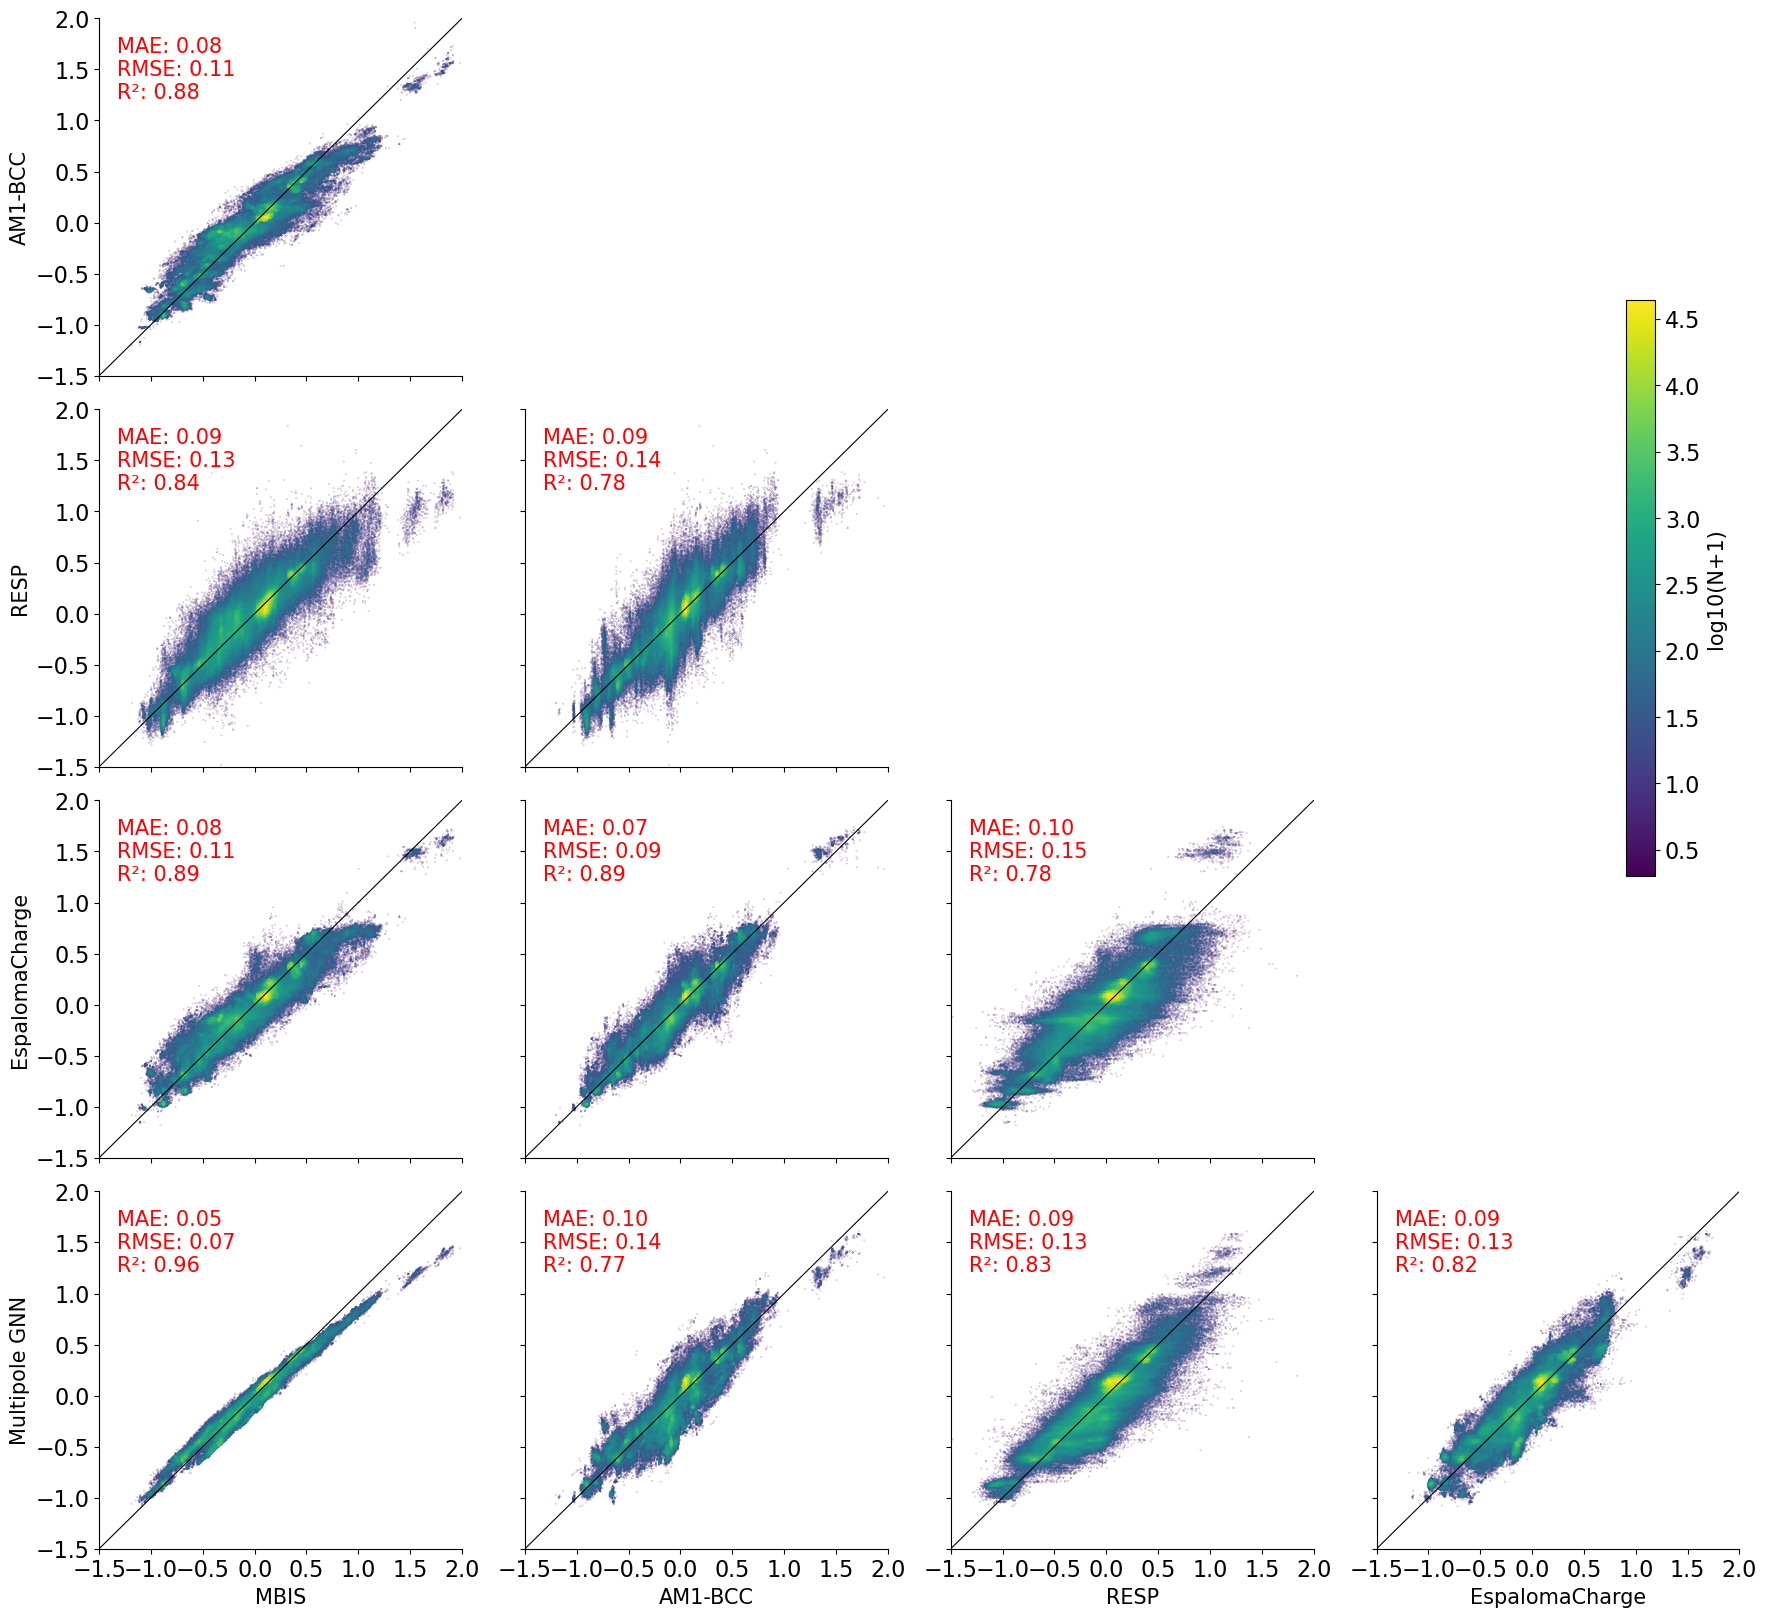

In [12]:
# 1. Set global figure font sizes, etc.
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# 2. Decide how many columns we have, and how wide the figure should be in inches.
# n_vars = len(df.columns)
desired_width = 4.5   # single column width in inches (ACS)

# Corner plot means n_vars - 1 subplots in the longest row
# n_subplots = n_vars - 1
height_each = 4.5
aspect = (desired_width /height_each)

mbis_charges_flat = np.concatenate(df['mbis_charges'].values)
am1bcc_charges_flat = np.concatenate(df['am1bcc_charges'].values)
resp_charges_flat = np.concatenate(df['resp_charges'].values)
espaloma_charges_flat = np.concatenate(df['espaloma_charges'].values)
multipole_gnn_charges_flat = np.concatenate(df['riniker_monopoles'].values)

charges_df = pd.DataFrame({
    "MBIS": mbis_charges_flat,
    "AM1-BCC": am1bcc_charges_flat,
    "RESP": resp_charges_flat,
    "EspalomaCharge": espaloma_charges_flat,
    "Multipole GNN": multipole_gnn_charges_flat
})

g = sns.PairGrid(charges_df,
                 height=height_each,
                 aspect=aspect,
                 diag_sharey=False,
                 corner=True)

# Plot the density as a 2D histogram instead of scatter
g.map_offdiag(density_scatter, bins=150, range=[(-1.5, 2), (-1.5, 2)], s=0.01)

# Add equality line y=x
for ax_row in g.axes:
    for ax in ax_row:
        if ax is not None:
            ax.plot([-1.5, 2], [-1.5, 2], color='black', linestyle='-', linewidth=0.8)

# Annotate metrics
g.map_offdiag(annotate_metrics)

# Remove diagonal plots
for ax in np.diag(g.axes):
    ax.set_visible(False)

# Set axis limits
g.set(xlim=(-1.5,2), ylim=(-1.5, 2))

# Label the axes on the outer edges
n = len(charges_df.columns)
for i, ax_row in enumerate(g.axes):
    for j, ax in enumerate(ax_row):
        if ax is not None:
            if i == n - 1:
                ax.set_xlabel(charges_df.columns[j], fontsize=15)
            if j == 0:
                ax.set_ylabel(charges_df.columns[i], fontsize=15)

g.fig.subplots_adjust(top=0.9)

ticks = np.arange(-1.5, 2.1, 0.5)  # or whatever interval you prefer
g.set(xticks=ticks, yticks=ticks)

# g.fig.suptitle('Pairwise Comparison of Charge Models (log-density)', fontsize=16)

scatter = None
for ax_row in g.axes:
    for ax in ax_row:
        if ax and len(ax.collections) > 0:
            # The scatter plot is a PathCollection in ax.collections
            # We set norm and cmap on the scatter itself, so let's find it
            candidate = [c for c in ax.collections if hasattr(c, 'norm')]
            if candidate:
                scatter = candidate[0]
                break
    if scatter is not None:
        break
# Filter out None axes
valid_axes = [ax for ax_row in g.axes for ax in ax_row if ax is not None]

if scatter is not None:
    from matplotlib.cm import ScalarMappable
    sm = ScalarMappable(norm=scatter.norm, cmap=scatter.cmap)
    sm.set_array([])
    g.fig.subplots_adjust(right=0.85)  # Move figure edge closer, thus bringing the colorbar in

    cbar = g.fig.colorbar(sm, ax=valid_axes, shrink=0.3,pad=-0.3)
    cbar.set_label('log10(N+1)', fontsize=15)


plt.savefig('pairwise_partial_charges_density_2.png', dpi=300, bbox_inches='tight')
plt.show()


In [28]:
charges_df

MBIS  \
0      [-0.22269026300546416, 0.0986548857271199, -0....   
1      [-0.307478181466797, -0.32475236546718506, 0.0...   
2      [0.18318003045342993, -0.2598634431943842, -0....   
3      [-0.27024134000385275, -0.2514930826279807, 0....   
4      [-0.25576208790277083, -0.2525614470001997, 0....   
...                                                  ...   
34923  [-0.4307936125045173, 0.35266299719448524, -0....   
34924  [-0.446016524842485, 0.4470529110725375, -0.40...   
34925  [-0.316128375134428, -0.30531925078170524, 0.5...   
34926  [-0.3033673079675967, 0.126306495949047, -0.70...   
34927  [-0.35189626351936343, 0.17665521845659918, -0...   

                                                 AM1-BCC  \
0      [-0.0894, 0.1548, -0.7962, 0.1548, -0.0894, -0...   
1      [-0.1269, -0.1269, -0.111, -0.0814, 0.1528, -0...   
2      [0.1214, -0.0273, -0.3572, 0.1952, -0.3976, 0....   
3      [-0.1094, -0.0984, 0.1401, -0.4256, 0.1264, 0....   
4      [-0.11239999999999999, -0.11339999999999999, 0...   
...                                                  ...   
34923  [-0.10315252631578949, 0.13044747368421053, -0...   
34924  [-0.10454736842105264, 0.23015263157894736, -0...   
34925  [-0.08515876470588235, -0.2840587647058823, 0....   
34926  [-0.11685454545454546, 0.15534545454545454, -0...   
34927  [-0.06690012, -0.022400119999999992, -0.213000...   

                                                    RESP  \
0      [-0.055, 0.0874, -0.8195, 0.0874, -0.055, 0.10...   
1      [-0.3026, -0.3026, 0.1671, -0.0841, 0.0157, -0...   
2      [-0.074, 0.0126, -0.2653, 0.0956, -0.3139, 0.0...   
3      [-0.1146, -0.0616, 0.4422, -0.553, 0.1441, 0.0...   
4      [-0.0219, -0.0166, 0.0911, 0.2138, -0.3633, 0....   
...                                                  ...   
34923  [-0.3234, 0.422, -0.3234, 0.0835, -0.1508, -0....   
34924  [-0.3489, 0.6182, -0.3489, -0.2262, 0.0329, -0...   
34925  [-0.2141, 0.1522, 0.4158, -0.4675, 0.4107, -0....   
34926  [-0.1849, 0.2184, -0.8421, 0.2184, -0.1849, 0....   
34927  [-0.2257, 0.1275, -0.508, -0.189, 0.1974, -0.4...   

                                         EspalomaCharges  \
0      [-0.07576356260549455, 0.0697487351440248, -0....   
1      [-0.17321058894906724, -0.17321058894906724, -...   
2      [0.10370072921117147, -0.2081667164961497, -0....   
3      [-0.22874532377018647, -0.18081164097084718, 0...   
4      [-0.16070350436937242, -0.1910425963855925, 0....   
...                                                  ...   
34923  [-0.16938045071928123, 0.23442702544362923, -0...   
34924  [-0.16086909488627785, 0.28039979620983724, -0...   
34925  [-0.11128084328682984, -0.2857638296178159, 0....   
34926  [-0.15900079397992653, 0.0887342444197698, -0....   
34927  [-0.17873125702142714, -0.04560554951429367, -...   

                                           Multipole GNN  
0      [-0.30706286430358887, 0.01613098382949829, -0...  
1      [-0.3678119480609894, -0.37190431356430054, 0....  
2      [0.07321783900260925, -0.32436901330947876, -0...  
3      [-0.31097567081451416, -0.3029680848121643, 0....  
4      [-0.2950514853000641, -0.3121240437030792, 0.1...  
...                                                  ...  
34923  [-0.5688874125480652, 0.35258910059928894, -0....  
34924  [-0.5875690579414368, 0.4356086552143097, -0.5...  
34925  [-0.41569340229034424, -0.336565226316452, 0.4...  
34926  [-0.35558021068573, 0.039914488792419434, -0.6...  
34927  [-0.4849037528038025, 0.20588380098342896, -0....  

[34928 rows x 5 columns]

In [ ]:
# Define the columns to check
compare_columns = ['mbis_dipoles', 'am1bcc_dipole', 'espaloma_dipole', 'riniker_dipoles', 'resp_dipole']

# Filter the DataFrame to include only the compare_columns
columns_to_check = [col for col in compare_columns if col in df.columns]
df_subset = df[columns_to_check]

# Find non-numeric values in the subset
non_numeric = df_subset.applymap(lambda x: not pd.api.types.is_number(x))

# Identify rows and columns containing non-numeric values
non_numeric_rows = non_numeric.any(axis=1)  # Rows with non-numeric values
non_numeric_columns = non_numeric.any(axis=0)  # Columns with non-numeric values

# Display problematic rows
print("Rows with non-numeric values in specified columns:")
print(df_subset[non_numeric_rows])

# Display problematic columns
print("\nColumns with non-numeric values:")
print(df_subset.loc[:, non_numeric_columns])

# For debugging purposes: show the problematic entries
print("\nProblematic entries:")
for row_idx, col_name in zip(*np.where(non_numeric)):
    print(f"Row {row_idx}, Column '{col_name}': {df_subset.iloc[row_idx][col_name]}")
